In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [6]:
data_lag = pd.read_csv("data_lagged.csv")
data = pd.read_csv('data_vad.csv')

In [8]:
data = data.drop(["filename"], axis = 1).dropna()

### Разделение данных

In [16]:
# для данных без погружения
X1 = data[data["label"] == 1]["batch_id"].unique()
X2 = data[data["label"] == 2]["batch_id"].unique()
X3 = data[data["label"] == 3]["batch_id"].unique()
X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train = data[data["batch_id"].apply(lambda x: x in X_train)].drop(['label', 'batch_id', 'msec'], axis = 1)
data_test = data[data["batch_id"].apply(lambda x: x in X_test)].drop(['label', 'batch_id', 'msec'], axis = 1)

In [17]:
# для данных с погружением
X1 = data_lag[data_lag["label"] == 1]["batch_id"].unique()
X2 = data_lag[data_lag["label"] == 2]["batch_id"].unique()
X3 = data_lag[data_lag["label"] == 3]["batch_id"].unique()
X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train_lag = data_lag[data_lag["batch_id"].apply(lambda x: x in X_train)].drop(['label', 'batch_id', 'msec'], axis = 1)
data_test_lag = data_lag[data_lag["batch_id"].apply(lambda x: x in X_test)].drop(['label', 'batch_id', 'msec'], axis = 1)

### Стандартизация данных

In [19]:
mean = data_train.mean(axis = 0)
mean_lag = data_train_lag.mean(axis = 0)
std = data_train.std(axis = 0)
std_lag = data_train_lag.std(axis = 0)

In [20]:
data_train -= mean
data_train_lag -= mean_lag
data_train /= std
data_train_lag /= std_lag

In [21]:
data_test -= mean
data_test_lag -= mean_lag
data_test /= std
data_test_lag /= std_lag

### Конечное разделение на матрицу признаков и на вектор предсказываемой величины

In [26]:
# для данных без погружения
X = data_train.iloc[:,:3]
X_test = data_test.iloc[:,:3]
y_valence = data_train.iloc[:,3:4]
y_arousal = data_train.iloc[:,4:]
y_valence_test = data_test.iloc[:,3:4]
y_arousal_test = data_test.iloc[:,4:]

In [30]:
# для данных с погружением
X_lag = data_train_lag.drop(['Valence', 'Arousal'], axis = 1)
X_test_lag = data_test_lag.drop(['Valence', 'Arousal'], axis = 1)
y_valence_lag = data_train_lag.iloc[:,3:4]
y_arousal_lag = data_train_lag.iloc[:,4:5]
y_valence_test_lag = data_test_lag.iloc[:,3:4]
y_arousal_test_lag = data_test_lag.iloc[:,4:5]

### Общая функция оценки моделей

In [106]:
def model_NN(X, y, X_test, y_test, input_n, output_n):
    model = Sequential()
    model.add(Dense(input_n, input_dim = input_n, activation = 'relu'))
    model.add(Dense(output_n, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam')
    m = model.fit(X, y, epochs = 300, verbose = 0)

    model.fit(X, y, verbose = 0)
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    m["R2_train"]['SingleLayerPerceptron'] = r2_score(y, model.predict(X, verbose = 0))
    m["MAE_train"]['SingleLayerPerceptron'] = mean_absolute_error(y, model.predict(X, verbose = 0))
    m["MSE_train"]['SingleLayerPerceptron'] = mean_squared_error(y, model.predict(X, verbose = 0))
    m["R2_test"]['SingleLayerPerceptron'] = r2_score(y_test, model.predict(X_test, verbose = 0))
    m["MAE_test"]['SingleLayerPerceptron'] = mean_absolute_error(y_test, model.predict(X_test, verbose = 0))
    m["MSE_test"]['SingleLayerPerceptron'] = mean_squared_error(y_test, model.predict(X_test, verbose = 0))
    return pd.DataFrame(m)

### Модели без погружения

In [107]:
mtv = model_NN(X, y_valence, X_test, y_valence_test, 3, 1)
mta = model_NN(X, y_arousal, X_test, y_arousal_test, 3, 1)

### Модели с погружением

In [108]:
mtv_lag = model_NN(X_lag, y_valence_lag, X_test_lag, y_valence_test_lag, 20, 1)
mta_lag = model_NN(X_lag, y_arousal_lag, X_test_lag, y_arousal_test_lag, 20, 1)

# Сравнение моделей

In [109]:
# Valence
mtv['Модель'] = ["Без погружения и без подбора параметров"]
mtv_lag['Модель'] = ["С погружением, без подбора параметров"]
df_Valence = mtv.append(mtv_lag)

#Arousal
mta['Модель'] = ["Без погружения и без подбора параметров"]
mta_lag['Модель'] = ["С подбором параметров, без погружения"]
df_Arousal = mta.append(mta_lag)

### Отложенная выборка 

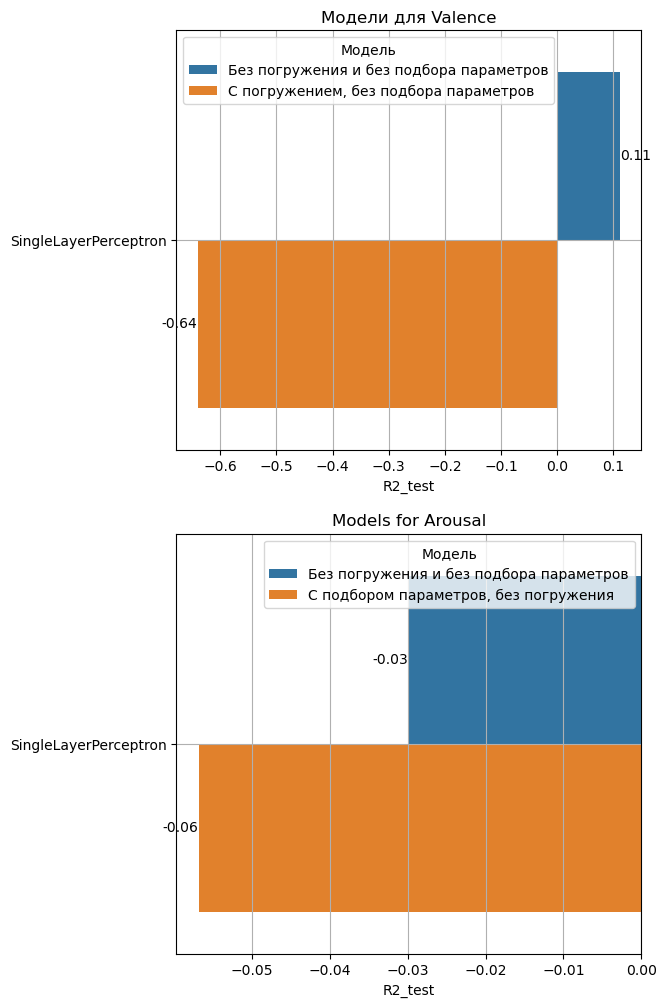

In [124]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
ax = sns.barplot(data = df_Valence, x = 'R2_test', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Valence')
plt.grid()

plt.subplot(212)
ax = sns.barplot(data = df_Arousal, x = 'R2_test', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Models for Arousal')
plt.grid()

plt.show()

## Тренировочная выборка

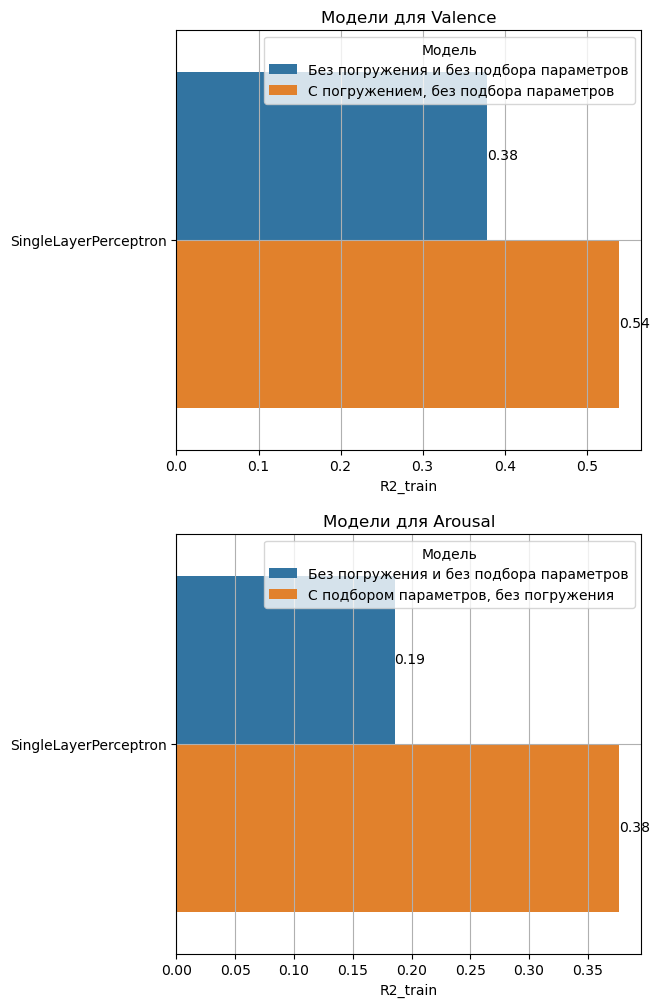

In [125]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
ax = sns.barplot(data = df_Valence, x = 'R2_train', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Valence')
plt.grid()

plt.subplot(212)
ax = sns.barplot(data = df_Arousal, x = 'R2_train', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Arousal')
plt.yticks()
plt.grid()

plt.show()

## Сохранение результатов работы моделей

In [127]:
with pd.ExcelWriter('Model_results.xlsx', mode="a") as writer:
    df_Arousal.to_excel(writer, sheet_name='Results_SingleLayerPerceptron_Arousal')
    df_Valence.to_excel(writer, sheet_name='Results_SingleLayerPerceptron_Valence')